In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import json
import pandas as pd
from nltk.corpus import stopwords, wordnet

In [2]:
batch_size = 64
epochs = 100
latent_dim = 256
num_samples = 800

In [3]:
#Abro el archivo en el que se encuentra el dataset de los problemas
with open('singleop.json', 'r') as f:
    datastore = json.load(f)

In [4]:
# Archivo que contiene un listado de nombres
nombres = pd.read_csv('nombres-2015.csv')
names = pd.read_csv('yob2019.txt', header=None)  
dataset2 = pd.read_csv('problemas_adicionales2.csv')

In [5]:
preguntas = []
respuestas = []
ecuaciones = []
alineacion = []

for item in datastore:
    preguntas.append(item['sQuestion'])
    respuestas.append(item['lSolutions'])
    ecuaciones.append(item['lEquations'])
    alineacion.append(item['lAlignments'])

In [6]:
# Necesito convertir el dataset en un problema de clasificacion para que la red neuronal pueda identificar
# si estoy tratando de resolver un problema de sumas, restas, multiplicaciones o divisiones.
# Esto va a crear una lista con el tipo de operacion y que va a ser el resultado a inferir.
operaciones = []
sumas =0
restas =0
multiplicaciones =0
divisiones = 0
otras = 0
#Clasifico las operaciones en 0 para sumas, 1 para restas, 2 para multiplicaciones, 3 para divisiones y 4 sino lo encuentro.
for operacion in ecuaciones:
    if (operacion[0].find('+')>=0):
        operaciones.append(0)
        sumas = sumas + 1
    elif (operacion[0].find('-') >= 0 ):
        operaciones.append(1)
        restas = restas + 1
    elif(operacion[0].find('*') >=0):
        operaciones.append(2)
        multiplicaciones = multiplicaciones + 1
    elif(operacion[0].find('/')):
        operaciones.append(3)
        divisiones = divisiones + 1
    else:
        operaciones.append(4)
        otras = otras + 1

print('Tengo ', sumas, ' sumas ', restas, ' restas, ', multiplicaciones, ' multiplicaciones, ', divisiones, ' divisiones y otras operaciones ', otras)

Tengo  159  sumas  162  restas,  117  multiplicaciones,  124  divisiones y otras operaciones  0


In [7]:
preguntas2 = dataset2['Preguntas'].tolist()
respuestas2 = dataset2['respuestas'].tolist()
preguntas3 = preguntas + preguntas2
respuestas3 = operaciones + respuestas2


In [8]:
#El listado de nombres lo voy a truncar a los 15K primeros, dado que el resto son nombres muy residuales.
stop_words = set(stopwords.words('spanish'))
nombres_ = nombres['nombre'][:15000]
names_= names[0]
nombres_ = nombres_.append(names_)
st_words = list(stop_words)
nom = nombres['nombre'].values.tolist()
nomb =  nom + st_words

In [9]:
# El vector preguntas_sin, consiste en las preguntas a las que voy a eliminar todos los nombres propios que no
# anaden ningun valor al conjunto de preguntas. No quiero que esos nombres se procesen y por tanto los elimino.
def eliminar_palabras(dataset, stopw):
    preguntas_sin = []
    for palabras in dataset:
        frases = [word for word in palabras.split(' ') if word not in stopw]
        frases = " ".join(frases)
        preguntas_sin.append(frases)
    return preguntas_sin

In [10]:
# Eliminamos todas las palabras que sobran pasamos todo el conjunto a minúsculas.
preguntas_min = []

preguntas_sin = eliminar_palabras(preguntas3, nomb)
for pregunta in preguntas_sin:
    preguntas_min.append(pregunta.lower())
    

In [11]:
preguntas_min = preguntas_sin + preguntas3 + preguntas_min
respuestas3 = respuestas3 * 3

In [12]:
input_texts = []
target_texts = []
#eliminar_caracteres = ['$', '&', '.', '\xa0', '“', '”']
input_characters = set()
target_characters = set()

for pregunta in preguntas_min:
    for palabra in pregunta:
        for caracter in palabra:
            if(caracter not in input_characters):
#                if(caracter not in eliminar_caracteres):
                    input_characters.add(caracter)
                
for respuesta in respuestas3:
    if (respuesta not in target_characters):
        target_characters.add(respuesta)
        
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in preguntas_min])
max_decoder_seq_length = 1

In [13]:
respuestas3

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,


In [14]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
encoder_input_data = np.zeros((len(preguntas_min), max_encoder_seq_length, num_encoder_tokens), dtype = "float32")
decoder_input_data = np.zeros((len(preguntas_min), 1, num_decoder_tokens), dtype = 'float32')
decoder_target_data = np.zeros((len(preguntas_min), 1, num_decoder_tokens), dtype = 'float32')

In [15]:
input_token_index

{' ': 0,
 '$': 1,
 '&': 2,
 ',': 3,
 '.': 4,
 '/': 5,
 '0': 6,
 '1': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '9': 15,
 ':': 16,
 ';': 17,
 '?': 18,
 'A': 19,
 'B': 20,
 'C': 21,
 'D': 22,
 'E': 23,
 'F': 24,
 'G': 25,
 'H': 26,
 'I': 27,
 'J': 28,
 'K': 29,
 'L': 30,
 'M': 31,
 'N': 32,
 'O': 33,
 'P': 34,
 'Q': 35,
 'R': 36,
 'S': 37,
 'T': 38,
 'U': 39,
 'V': 40,
 'W': 41,
 'Y': 42,
 'Z': 43,
 'a': 44,
 'b': 45,
 'c': 46,
 'd': 47,
 'e': 48,
 'f': 49,
 'g': 50,
 'h': 51,
 'i': 52,
 'j': 53,
 'k': 54,
 'l': 55,
 'm': 56,
 'n': 57,
 'o': 58,
 'p': 59,
 'q': 60,
 'r': 61,
 's': 62,
 't': 63,
 'u': 64,
 'v': 65,
 'w': 66,
 'x': 67,
 'y': 68,
 'z': 69,
 '\xa0': 70,
 '¿': 71,
 'Á': 72,
 'É': 73,
 'á': 74,
 'é': 75,
 'í': 76,
 'ñ': 77,
 'ó': 78,
 'ú': 79,
 '“': 80,
 '”': 81,
 '€': 82}

In [16]:
for i, (pregunta, respuesta) in enumerate(zip(preguntas_min, respuestas3)):
        for j, caracter in enumerate(pregunta):
            encoder_input_data[i, j, input_token_index[caracter]] = 1.0
        decoder_input_data[i, 0, respuesta] = 1.0
        if respuesta > 0:
            decoder_target_data[i, 0, respuesta-1] = 1.0

In [17]:
encoder_inputs = keras.Input(shape = (None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, dropout= 0.2, return_state = True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape = (None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim, dropout= 0.2, recurrent_dropout = 0.2, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation = "softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [18]:
model.compile(optimizer = "rmsprop", loss="categorical_crossentropy", metrics = ['accuracy'])

history = model.fit([encoder_input_data, decoder_input_data],
         decoder_target_data,
         batch_size = batch_size,
         epochs = epochs,
         validation_split = 0.2)

Epoch 1/100
37/37 [==============================] - 43s 1s/step - loss: 0.7523 - accuracy: 0.5653 - val_loss: 0.6297 - val_accuracy: 0.6752
Epoch 2/100
37/37 [==============================] - 44s 1s/step - loss: 0.4998 - accuracy: 0.7976 - val_loss: 0.5179 - val_accuracy: 0.5402
Epoch 3/100
37/37 [==============================] - 42s 1s/step - loss: 0.2887 - accuracy: 0.8434 - val_loss: 0.2146 - val_accuracy: 0.7983
Epoch 4/100
37/37 [==============================] - 39s 1s/step - loss: 0.1775 - accuracy: 0.8528 - val_loss: 0.0598 - val_accuracy: 1.0000
Epoch 5/100
37/37 [==============================] - 41s 1s/step - loss: 0.1191 - accuracy: 0.8742 - val_loss: 0.0243 - val_accuracy: 1.0000
Epoch 6/100
37/37 [==============================] - 47s 1s/step - loss: 0.0883 - accuracy: 0.8639 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 7/100
37/37 [==============================] - 43s 1s/step - loss: 0.0702 - accuracy: 0.8729 - val_loss: 0.0182 - val_accuracy: 0.7983
Epoch 8/100
3

37/37 [==============================] - 40s 1s/step - loss: 9.1073e-04 - accuracy: 0.9059 - val_loss: 9.5164e-08 - val_accuracy: 1.0000
Epoch 58/100
37/37 [==============================] - 45s 1s/step - loss: 0.0018 - accuracy: 0.8395 - val_loss: 9.5164e-08 - val_accuracy: 1.0000
Epoch 59/100
37/37 [==============================] - 41s 1s/step - loss: 0.0027 - accuracy: 0.9585 - val_loss: 9.5164e-08 - val_accuracy: 1.0000
Epoch 60/100
37/37 [==============================] - 39s 1s/step - loss: 0.0013 - accuracy: 0.7788 - val_loss: 9.5164e-08 - val_accuracy: 0.7983
Epoch 61/100
37/37 [==============================] - 46s 1s/step - loss: 0.0020 - accuracy: 0.9024 - val_loss: 9.5164e-08 - val_accuracy: 1.0000
Epoch 62/100
37/37 [==============================] - 39s 1s/step - loss: 7.8090e-05 - accuracy: 0.9409 - val_loss: 9.5164e-08 - val_accuracy: 0.7983
Epoch 63/100
37/37 [==============================] - 42s 1s/step - loss: 0.0035 - accuracy: 0.9033 - val_loss: 9.5164e-08 - val_

In [19]:
import matplotlib.pyplot as plt

def resultados(history):
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

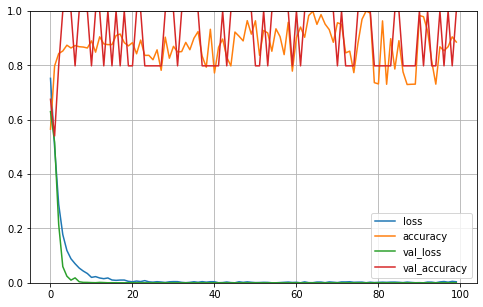

In [20]:
resultados(history)

In [33]:
question = 'Pedro tiene 5 monedas y su abuela le da 3 más, ¿Cuántas monedas tiene en total?'

In [44]:
question = 'Pedro tiene 2 platanos y compra 3 más, ¿Cuántos platanos suman en total?'

In [48]:
question = 'Pablo tiene 3 bolis y su hermana le pierde uno, ¿Cuántos bolis le quedan a Pablo?'

In [51]:
question = 'Si una semana tiene 7 días, ¿Cuántos días tienen 3 semanas?'

In [52]:
encoder_question_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype = "float32")

In [53]:
for j, caracter in enumerate(question):
    encoder_question_data[0, j, input_token_index[caracter]] = 1.0

In [25]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 83)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 348160      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  267264      input_2[0][0]                    
                                                                 lstm[0][1]            

In [55]:
encoder_inputs = model.input[0]  # El input de entrada de la primera capa.
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # Las 3 salidas de la capa LSTM
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
resp = np.array([0,1,2,3])
#target_token_index = dict([(char, i) for i, char in enumerate(resp)])
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
#reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def responder(input_seq):
    # Predecimos la secuencia de entrada con nuestro modelo.
    states_value = encoder_model.predict(input_seq)

    # Genero un vector objetivo de tamaño igual a 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    print(output_tokens)
    return sampled_token_index

In [56]:
responder(encoder_question_data)

[[[4.0605095e-01 4.6138111e-01 1.3256747e-01 3.6267679e-07]]]


1

In [47]:
responder(encoder_question_data)

[[[4.0603819e-01 4.6140924e-01 1.3255227e-01 3.6266948e-07]]]


1

In [ ]:
model.predict([encoder_question_data, resp])

In [ ]:
resp